# Transfer learning for susceptibility distortion correction

In [5]:
# Imports
import os
import numpy as np
import dipy
from dipy.io.image import load_nifti, save_nifti
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.colors import LinearSegmentedColormap
from dipy.io.image import load_nifti, save_nifti
from dipy.viz import regtools
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from scipy.ndimage import sobel, binary_erosion, gaussian_gradient_magnitude

In [6]:
img_1, _ = load_nifti('data/AP/100206.nii.gz')
img_2, _ = load_nifti('data/PA/100307.nii.gz')
T1, _ = load_nifti('data/T1/100206.nii.gz')
T1_edges = gaussian_gradient_magnitude(T1, sigma=1)

In [7]:
img_1.shape

(128, 128, 128)

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        tf.print(e)

# This is telling the default strategy for multi-GPUs
strategy = tf.distribute.MirroredStrategy()

# setting batch size. 1 per each gpu in this case.
BATCH_SIZE_PER_REPLICA = 1
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [9]:
def regular_grid_3d(depth, height, width):
    i = tf.linspace(-1.0, 1.0, depth)
    j = tf.linspace(-1.0, 1.0, height)
    k = tf.linspace(-1.0, 1.0, width)

    I, J, K = tf.meshgrid(i, j, k, indexing='ij')

    grid = tf.stack([I, J, K], axis=-1)
    return grid

In [10]:
def grid_sample_3d(moving, grid):
    nb, nd, nh, nw, nc = tf.shape(moving)

    i = grid[..., 0]  # shape (N, D, H, W)
    j = grid[..., 1]
    k = grid[..., 2]
    i = tf.cast(i, 'float32')
    j = tf.cast(j, 'float32')
    k = tf.cast(k, 'float32')

    # Scale i, j and k from [-1.0, 1.0] to [0, D], [0, H] and [0, W] respectively.
    i = (i + 1.0) * 0.5 * tf.cast(nd-1, 'float32')
    j = (j + 1.0) * 0.5 * tf.cast(nh-1, 'float32')
    k = (k + 1.0) * 0.5 * tf.cast(nw-1, 'float32')

    i_max = tf.cast(nd - 1, 'int32')
    j_max = tf.cast(nh - 1, 'int32')
    k_max = tf.cast(nw - 1, 'int32')
    zero = tf.constant(0, 'int32')

    # The value at (i, j, k) is a weighted average of the values at the
    # eight nearest integer locations: (i0, j0, k0), (i0, j0, k1), (i0, j1, k0),
    # (i0, j1, k1), (i1, j0, k0), (i1, j0, k1), (i1, j1, k0) and (i1, j1, k1)
    # where i0 = floor(i), i1 = ceil(i).
    i0 = tf.cast(tf.floor(i), 'int32')
    i1 = i0 + 1
    j0 = tf.cast(tf.floor(j), 'int32')
    j1 = j0 + 1
    k0 = tf.cast(tf.floor(k), 'int32')
    k1 = k0 + 1

    # Make sure indices are within the boundaries of the image.
    i0 = tf.clip_by_value(i0, zero, i_max)
    i1 = tf.clip_by_value(i1, zero, i_max)
    j0 = tf.clip_by_value(j0, zero, j_max)
    j1 = tf.clip_by_value(j1, zero, j_max)
    k0 = tf.clip_by_value(k0, zero, k_max)
    k1 = tf.clip_by_value(k1, zero, k_max)

    # Collect indices of the four corners.
    b = tf.ones_like(i0) * tf.reshape(tf.range(nb), [nb, 1, 1, 1])
    idx_a = tf.stack([b, i1, j0, k0], axis=-1)  # all front-top-left corners
    idx_b = tf.stack([b, i1, j1, k0], axis=-1)  # all front-bottom-left corners
    idx_c = tf.stack([b, i1, j0, k1], axis=-1)  # all front-top-right corners
    idx_d = tf.stack([b, i1, j1, k1], axis=-1)  # all front-bottom-right corners
    idx_e = tf.stack([b, i0, j0, k0], axis=-1)  # all back-top-left corners
    idx_f = tf.stack([b, i0, j1, k0], axis=-1)  # all back-bottom-left corners
    idx_g = tf.stack([b, i0, j0, k1], axis=-1)  # all back-top-right corners
    idx_h = tf.stack([b, i0, j1, k1], axis=-1)  # all back-bottom-right corners
    # shape (N, D, H, W, 3)

    # Collect values at the corners.
    moving_a = tf.gather_nd(moving, idx_a)  # all front-top-left values
    moving_b = tf.gather_nd(moving, idx_b)  # all front-bottom-left values
    moving_c = tf.gather_nd(moving, idx_c)  # all front-top-right values
    moving_d = tf.gather_nd(moving, idx_d)  # all front-bottom-right values
    moving_e = tf.gather_nd(moving, idx_e)  # all back-top-left values
    moving_f = tf.gather_nd(moving, idx_f)  # all back-bottom-left values
    moving_g = tf.gather_nd(moving, idx_g)  # all back-top-right values
    moving_h = tf.gather_nd(moving, idx_h)  # all back-bottom-right values
    # shape (N, D, H, W, C)

    i0_f = tf.cast(i0, 'float32')
    i1_f = tf.cast(i1, 'float32')
    j0_f = tf.cast(j0, 'float32')
    j1_f = tf.cast(j1, 'float32')
    k0_f = tf.cast(k0, 'float32')
    k1_f = tf.cast(k1, 'float32')

    # Calculate the weights.
    wa = tf.expand_dims((i - i0_f) * (j1_f - j) * (k1_f - k), axis=-1)
    wb = tf.expand_dims((i - i0_f) * (j - j0_f) * (k1_f - k), axis=-1)
    wc = tf.expand_dims((i - i0_f) * (j1_f - j) * (k - k0_f), axis=-1)
    wd = tf.expand_dims((i - i0_f) * (j - j0_f) * (k - k0_f), axis=-1)
    we = tf.expand_dims((i1_f - i) * (j1_f - j) * (k1_f - k), axis=-1)
    wf = tf.expand_dims((i1_f - i) * (j - j0_f) * (k1_f - k), axis=-1)
    wg = tf.expand_dims((i1_f - i) * (j1_f - j) * (k - k0_f), axis=-1)
    wh = tf.expand_dims((i1_f - i) * (j - j0_f) * (k - k0_f), axis=-1)

    # Calculate the weighted sum.
    moved = tf.add_n([wa * moving_a, wb * moving_b, wc * moving_c,
                      wd * moving_d, we * moving_e, wf * moving_f,
                      wg * moving_g, wh * moving_h])
    return moved

In [11]:
def voxelmorph1(input_shape=(128, 128, 1)):
    moving = layers.Input(shape=input_shape, name='moving')
    static = layers.Input(shape=input_shape, name='static')
    x_in = layers.concatenate([static, moving], axis=-1)

    # encoder
    x1 = layers.Conv3D(16, kernel_size=3, strides=2, padding='same',
                        kernel_initializer='he_normal')(x_in)
    x1 = layers.LeakyReLU(alpha=0.2)(x1)  # 16

    x2 = layers.Conv3D(32, kernel_size=3, strides=2, padding='same',
                        kernel_initializer='he_normal')(x1)
    x2 = layers.LeakyReLU(alpha=0.2)(x2)  # 8

    x3 = layers.Conv3D(32, kernel_size=3, strides=2, padding='same',
                        kernel_initializer='he_normal')(x2)
    x3 = layers.LeakyReLU(alpha=0.2)(x3)  # 4

    x4 = layers.Conv3D(32, kernel_size=3, strides=2, padding='same',
                        kernel_initializer='he_normal')(x3)
    x4 = layers.LeakyReLU(alpha=0.2)(x4)  # 2

    # decoder [32, 32, 32, 32, 8, 8]
    x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x4)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling3D(size=2)(x)  # 4
    x = layers.concatenate([x, x3], axis=-1)  # 4

    x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling3D(size=2)(x)  # 8
    x = layers.concatenate([x, x2], axis=-1)  # 8

    x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.UpSampling3D(size=2)(x)  # 16
    x = layers.concatenate([x, x1], axis=-1)  # 16

    x = layers.Conv3D(32, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv3D(8, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)  # 16

    x = layers.UpSampling3D(size=2)(x)  # 32
    x = layers.concatenate([x, x_in], axis=-1)
    x = layers.Conv3D(8, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)  # 32

    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,
                                                            stddev=1e-5)
    deformation = layers.Conv3D(3, kernel_size=3, strides=1,
                                padding='same',
                                kernel_initializer=kernel_initializer)(x)

    nb, nd, nh, nw, nc = tf.shape(deformation)

    # Regular grid.
    grid = regular_grid_3d(nd, nh, nw)  # shape (D, H, W, 2)
    grid = tf.expand_dims(grid, axis=0)  # shape (1, D, H, W, 2)
    multiples = tf.stack([nb, 1, 1, 1, 1])
    grid = tf.tile(grid, multiples)

    # Compute the new sampling grid.
    grid_new = grid + deformation
    grid_new = tf.clip_by_value(grid_new, -1, 1)

    # Sample the moving image using the new sampling grid.
    moved = grid_sample_3d(moving, grid_new)

    model = tf.keras.Model(inputs=[static, moving],
                            outputs=[moved, deformation], name='voxelmorph1')
    return model



def plot_images(model, moving, moving2, static):
    nb, nd, nh, nw, nc = moving.shape

    # Repeat the static image along the batch dim.
    # multiples = tf.constant([nb, 1, 1, 1, 1], tf.int32)
    # static = tf.tile(static, multiples)

    moved, deformation = model({'moving': moving, 'static': static}, training=False)
    moved2, deformation2 = model({'moving': moving2, 'static': static}, training=False)

    tf.print(deformation.shape, tf.reduce_max(deformation), tf.reduce_min(deformation), tf.reduce_mean(deformation))
    tf.print(deformation2.shape, tf.reduce_max(deformation2), tf.reduce_min(deformation2), tf.reduce_mean(deformation2))

    deformation = deformation.numpy()
    moved = moved.numpy().squeeze(axis=-1) * 255.0
    # moved = moved.astype(np.uint8)[:,:,nh//2,...]
    moving = moving.numpy().squeeze(axis=-1) * 255.0
    # moving = moving.astype(np.uint8)[:,:,nh//2,...]
    static = static.numpy().squeeze(axis=-1) * 255.0
    # static = static.astype(np.uint8)[:,:,nh//2,...]

    deformation2 = deformation2.numpy()
    moved2 = moved2.numpy().squeeze(axis=-1) * 255.0
    # moved = moved.astype(np.uint8)[:,:,nh//2,...]
    moving2 = moving2.numpy().squeeze(axis=-1) * 255.0
    # moving = moving.astype(np.uint8)[:,:,nh//2,...]

    # # Plot images.
    # fig = plt.figure(figsize=(3 * 1.7, nb * 1.7))
    # titles_list = ['Static', 'Moved', 'Moving']
    # images_list = [static, moved, moving]

    # moved = moving
    for i in range(nb):
        # for j in range(3):
        #     ax = fig.add_subplot(nb, 3, i * 3 + j + 1)
        #     if i == 0:
        #         ax.set_title(titles_list[j], fontsize=20)
        #     ax.set_axis_off()
        #     ax.imshow(images_list[j][i], cmap='gray')
        regtools.overlay_slices(static[i], moved[i], None, 0,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_0.png" % (i))
        regtools.overlay_slices(static[i], moved[i], None, 1,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_1.png" % (i))
        regtools.overlay_slices(static[i], moved[i], None, 2,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_2.png" % (i))
        
        regtools.overlay_slices(static[i], moved2[i], None, 0,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_0.png" % (i))
        regtools.overlay_slices(static[i], moved2[i], None, 1,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_1.png" % (i))
        regtools.overlay_slices(static[i], moved2[i], None, 2,
                                "%d Static"%i, "%d Transformed"%i,
                                "%d_2.png" % (i))
        d = {'static': static[i], 'moved': moved[i], 'moving': moving[i], 'deformation': deformation[i],
             'moved2': moved2[i], 'moving2': moving2[i], 'deformation2': deformation2[i]}
        np.save('drive/My Drive/DIPY/t1_t2/results/sample%d.npy'%(i), d)

    # plt.tight_layout()
    # plt.show()


In [14]:
def main(args):


    model = voxelmorph1(input_shape = (128, 128, 128, 1))
    model.load_weights('checkpoints/dMRI-model.h5')

    # Load the moving and static images.
    moving, _ = load_nifti('data/T1/100206.nii.gz')
    moving = np.expand_dims(moving, axis=0)
    moving = np.expand_dims(moving, axis=-1)
    moving = moving.astype(np.float32) / 255.0
    moving = tf.convert_to_tensor(moving)

    static, _ = load_nifti('data/T1/100307.nii.gz')
    static = np.expand_dims(static, axis=0)
    static = np.expand_dims(static, axis=-1)
    static = static.astype(np.float32) / 255.0
    static = tf.convert_to_tensor(static)

    # Infer the deformation field and moved image.
    moved, deformation = model({'moving': moving, 'static': static}, training=False)
    print(moved.shape, deformation.shape)
    # nb, nd, nh, nw, nc = moving.shape
    nb = moving.shape[0]
    print("nb: ", nb)
    tf.print(deformation.shape, tf.reduce_max(deformation), tf.reduce_min(deformation), tf.reduce_mean(deformation))

    deformation = deformation.numpy()
    moved = moved.numpy().squeeze(axis=-1) * 255.0
    moved = moved[0]
    print("moved: ", moved.shape)
    # moved = moved.astype(np.uint8)[:,:,nh//2,...]
    moving = moving.numpy().squeeze(axis=-1) * 255.0
    moving = moving[0]
    moving = moving[..., 0]
    print("moving: ", moving.shape)
    # moving = moving.astype(np.uint8)[:,:,nh//2,...]
    static = static.numpy().squeeze(axis=-1) * 255.0
    static = static[0]
    static = static[..., 0]
    print("static: ", static.shape)
    # static = static.astype(np.uint8)[:,:,nh//2,...]


    # Repeat the static image along the batch dim.
    # multiples = tf.constant([nb, 1, 1, 1, 1], tf.int32)
    # static = tf.tile(static, multiples)



In [15]:
if __name__ == '__main__':

    main(None)

(1, 128, 128, 128, 1) (1, 128, 128, 128, 3)
nb:  1
TensorShape([1, 128, 128, 128, 3]) 531.525208 -952.73468 -113.174904
moved:  (128, 128, 128)
moving:  (128, 128, 128)
static:  (128, 128, 128)


## Checking contours to verify that susceptibility distortion is corrected

In [18]:
from dipy.align import affine_registration
from dipy.align.reslice import reslice
def crossmodel_comparision(img1, img2, affine1, affine2, vox1, vox2):
    img1_resliced, affine1_resliced = reslice(img1, affine1, vox1, (0.5,0.5,0.5))
    img2_resliced, affine2_resliced = reslice(img2, affine2, vox2, (0.5,0.5,0.5))

    target_shape = (
    max(img1_resliced.shape[0], img2_resliced.shape[0]),
    max(img1_resliced.shape[1], img2_resliced.shape[1]),
    max(img1_resliced.shape[2], img2_resliced.shape[2])
    )
    pad_width_1 = [
    (0, target_shape[0] - img1_resliced.shape[0]),
    (0, target_shape[1] - img1_resliced.shape[1]),
    (0, target_shape[2] - img1_resliced.shape[2])
    ]

    pad_width_2 = [
    (0, target_shape[0] - img2_resliced.shape[0]),
    (0, target_shape[1] - img2_resliced.shape[1]),
    (0, target_shape[2] - img2_resliced.shape[2])
    ]

    padded_img1 = np.pad(img1_resliced, pad_width=pad_width_1, mode='constant', constant_values=0)
    padded_img2 = np.pad(img2_resliced, pad_width=pad_width_2, mode='constant', constant_values=0)

    #perform affine registration
    pipeline = ["center_of_mass", "translation", "rigid", "rigid_isoscaling", "rigid_scaling"]
    warped_padded_img2, warped_padded_img2_affine = affine_registration(
            padded_img2, padded_img1, moving_affine=affine2_resliced,
            static_affine=affine1_resliced, pipeline=pipeline)



    return (padded_img1, warped_padded_img2)

In [19]:
T1_edges, affine_T1 = load_nifti('data/final/102109_T1_edges.nii.gz')
syn, affine_syn = load_nifti('data/final/102109_syn_comparision.nii.gz')


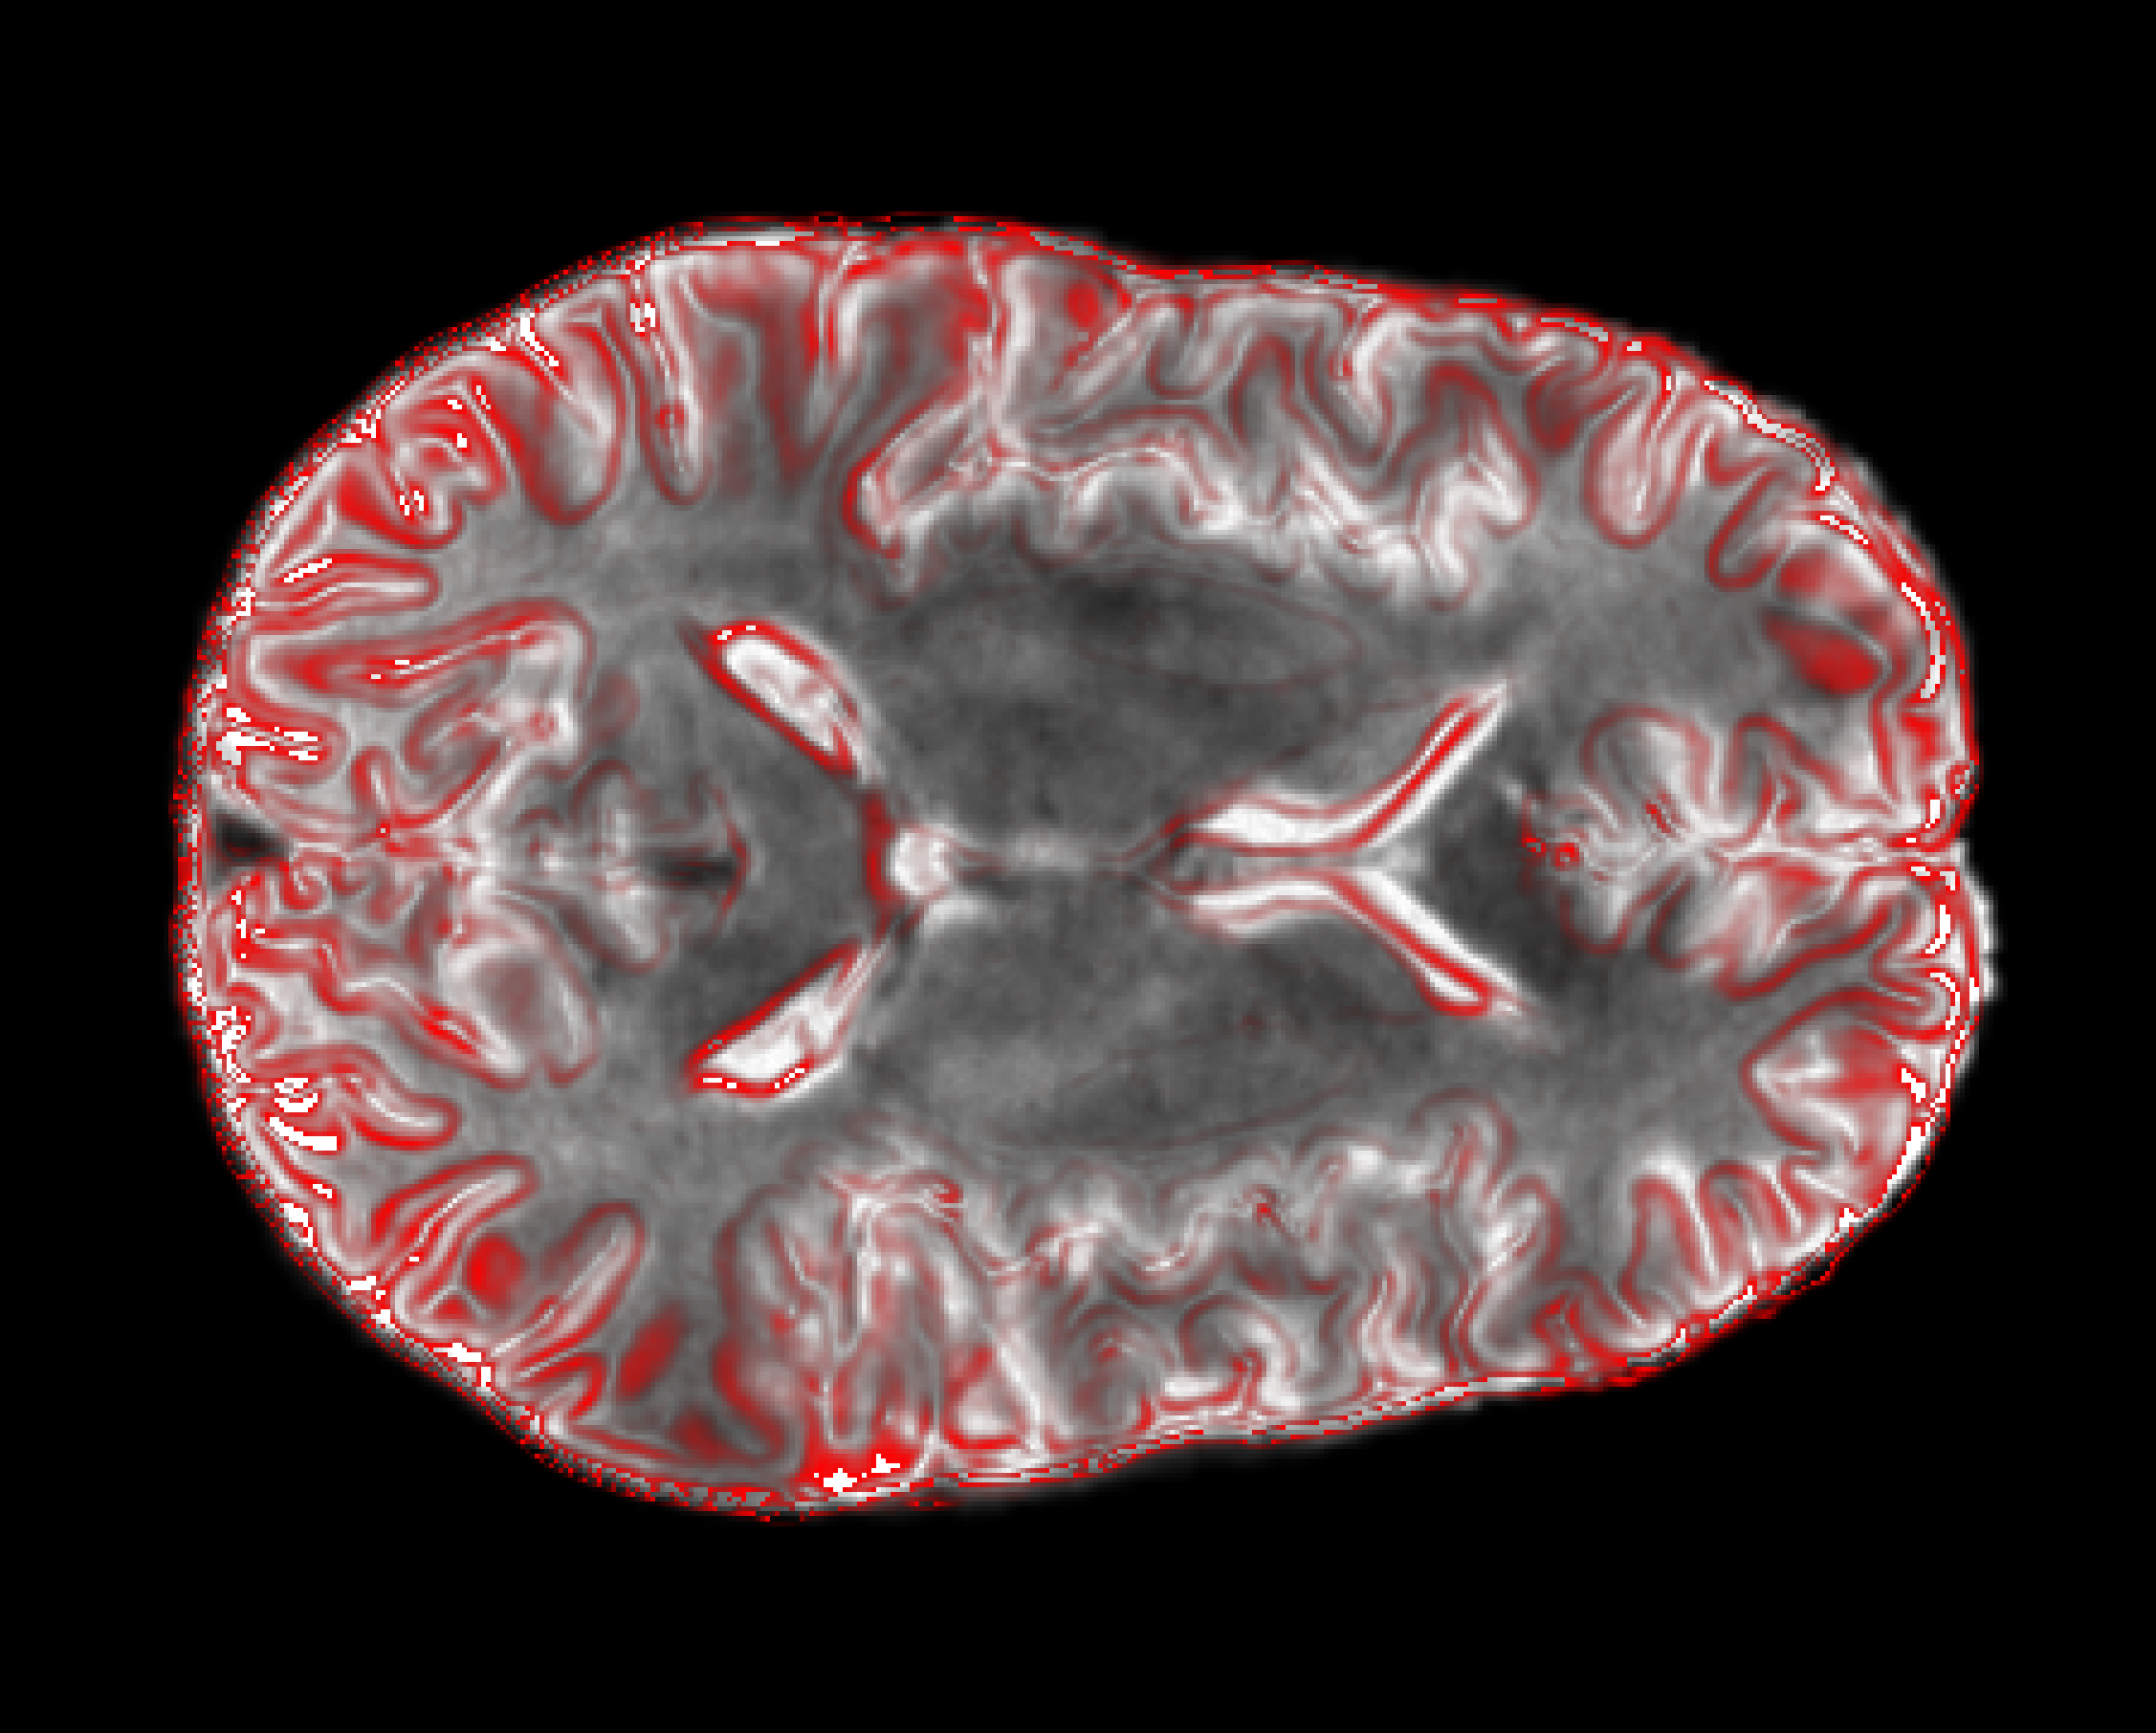

In [ ]:
# overlay two images
fig, ax = plt.subplots()
ax.imshow(syn[:,:,224], cmap='gray', alpha=1, vmax=7000)
ax.imshow(T1_edges[:,:,224], cmap= LinearSegmentedColormap.from_list('custom_cmap', [(0, 0, 0, 0), (1, 0, 0, 1)], N=256))
plt.axis('off')
# plt.savefig('figures/edges-3.png', bbox_inches='tight', pad_inches=0, dpi=600)